In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import watershed_udder as wu
import pyrealsense2 as rs
import numpy as np

import open3d as o3d

C:\Users\marie\miniconda3\envs\napari-env2\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# list files 
dirpath = os.getcwd()
ws_dir = r"validate_watershed\watershed_segments"
corr_dir = r"validate_watershed\watershed_correspondence"
label_dir = os.path.join(dirpath, r"validate_watershed\pred_labels")
kp_dir = os.path.join(label_dir, r"keypoints")
sg_dir = os.path.join(label_dir, r"segments")
img_dir = os.path.join(os.path.normpath(dirpath + os.sep + os.pardir), r"udder_video\depth_images")
results = pd.read_csv(r"validate_watershed\ws_class_predictions_I.csv")
video_path =  os.path.join(os.path.normpath(dirpath + os.sep + os.pardir), "udder_video", "video_files", "example_video.bag")
good = results[results.thr09 == 1]
filenames = [file.replace(".npy", "") for file in os.listdir(ws_dir)]

In [3]:
# get camera parameters
config = rs.config()
rs.config.enable_device_from_file(config, video_path, repeat_playback = False)
pipeline = rs.pipeline()
cfg = pipeline.start(config) # Start pipeline and get the configuration it found
profile = cfg.get_stream(rs.stream.depth) # Fetch stream profile for depth stream
intr = profile.as_video_stream_profile().get_intrinsics() # Downcast to video_stream_profile and fetch intrinsics
scale = 0.001

In [4]:
def points_toworld(points):
    points2 = points.copy()
    for i in range(len(points)):
        points2[i, :] = rs.rs2_deproject_pixel_to_point(intr, [points[i, 0], points[i, 1]], points[i, 2])
    return points2
# get image points
def pts_fromimg(coords, img):
    values = img[coords[:,1],  coords[:,0]]
    idx = np.where(values != 0)
    pts = np.column_stack((np.transpose(coords[idx,0]), np.transpose(coords[idx,1]), np.transpose(values[idx]))).astype(float)
    return pts
# 
def tilt_ponts(plane, old_points):
    a = plane[1]
    b = plane[2]
    c = -1
    d = plane[0]
    new_z = a *old_points[:, 0]+ b * old_points[:,1] + d
    new_points = old_points.copy()
    new_points[:, 2] = new_points[:, 2] - new_z
    return new_points
# 
def down_sample(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    downpcd = pcd.voxel_down_sample(voxel_size=0.005)
    return np.asarray(downpcd.points)

In [5]:
file = good.filename[1]

udder = wu.udder_object(file + ".tif", img_dir, label_dir, array = 0)
# read image
img = udder.img
# read labels
segment = udder.get_segment()
points = udder.get_keypoints()
# reas WS segmentation
ws_label = np.load(os.path.join(ws_dir, file + ".npy"))
kp_ws = pd.read_csv(os.path.join(corr_dir, file +".csv")).loc[0].to_dict()
# ws_map = dict((v, k) for k, v in kp_ws.items())
# ws_map[0] = "bg"
new_kp = wu.update_kp(kp_ws, ws_label, img)

kp_locs = np.array([np.array(value) for value in new_kp.values()])
kp_points = pts_fromimg(kp_locs, img)
kp_points2 = kp_points.copy()
kp_points2[:, 2] = kp_points[:, 2] *scale
kp = points_toworld(kp_points2)

plane_pts = kp[kp[:, 2].argsort()]
A = np.column_stack((np.ones((3,1)), plane_pts[:3, :2]))
B = np.reshape(plane_pts[:3, 2], (3,1))
plane = np.linalg.inv(np.transpose(A)@A)@np.transpose(A)@B

kp2 = tilt_ponts(plane, kp)
kp_dict = {key: kp2[i, :] for i, key in enumerate(new_kp.keys())}

In [6]:
# get lf pcd
key = "lf" 
label = kp_ws[key]
rows, cols = np.where(ws_label == label)
qlocs = np.column_stack([np.transpose(cols), np.transpose(rows)])
qlocs2 = pts_fromimg(qlocs, img)

qcoords = qlocs2.copy()
qcoords[:, 2] = qcoords[:, 2]*scale
qxyz = points_toworld(qcoords)

txyz_t = kp_dict[key]
qxyz_t = tilt_ponts(plane, qxyz)

In [60]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, Sum, CompoundKernel

In [24]:
# fit model and predict
# downsample
dpcd = down_sample(qxyz_t)
x = dpcd[:, :2]
y = dpcd[:, 2]

In [68]:
kernel = Sum(1*RBF(), 1*RBF())

In [69]:
gaussian_process = GaussianProcessRegressor(kernel=kernel, random_state = 5)
gaussian_process.fit(x, y)

C:\Users\marie\miniconda3\envs\napari-env2\lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\marie\miniconda3\envs\napari-env2\lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + 1**2 * RBF(length_scale=1),
                         random_state=5)

In [70]:
gaussian_process.kernel_.get_params()

{'k1': 0.0981**2 * RBF(length_scale=1e-05),
 'k2': 0.0981**2 * RBF(length_scale=1e-05),
 'k1__k1': 0.0981**2,
 'k1__k2': RBF(length_scale=1e-05),
 'k1__k1__constant_value': 0.009627345746277235,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': 9.999999999999997e-06,
 'k1__k2__length_scale_bounds': (1e-05, 100000.0),
 'k2__k1': 0.0981**2,
 'k2__k2': RBF(length_scale=1e-05),
 'k2__k1__constant_value': 0.009627345746277235,
 'k2__k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__k2__length_scale': 9.999999999999997e-06,
 'k2__k2__length_scale_bounds': (1e-05, 100000.0)}

In [71]:
gaussian_process.kernel_.theta

array([ -4.64314771, -11.51292546,  -4.64314771, -11.51292546])

In [104]:
all_dist = [np.linalg.norm(x[i, :2]-txyz_t[:2]) for i in range(len(x))]

In [105]:
dif = np.array([x[i, :2]-txyz_t[:2] for i in range(len(x))])
angle = [np.arctan(dif[i, 1]/dif[i, 0]) if dif[i, 0]!=0 else 0 for i in range(len(dif))]

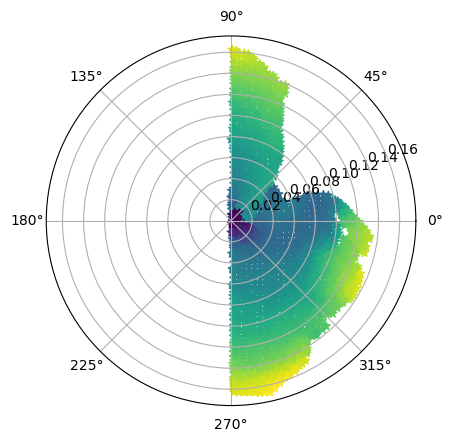

In [107]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(angle, all_dist, marker = "*", c = y, cmap = "viridis")

In [86]:
[i for i in range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

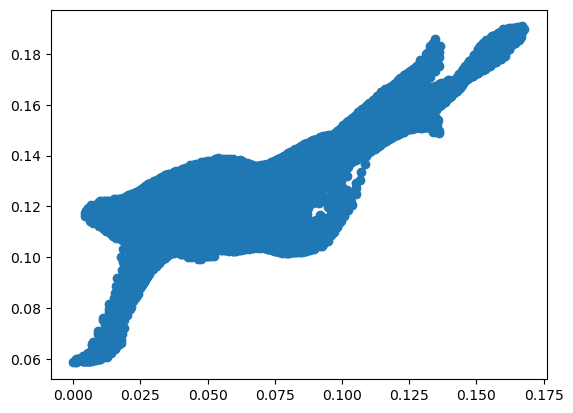

In [70]:
plt.scatter(all_dist, qxyz_t[:, 2])